In [1]:
#multi channel CNN for sentiment analysis
from nltk.corpus import stopwords
from string import punctuation
import pandas as pd
import numpy as np
import re
import csv
import codecs
import word2vecReader as godin_embedding
import pickle
from random import shuffle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import Adam
from keras.layers.merge import concatenate
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
from math import sqrt
from gensim.models import KeyedVectors
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
#loading data
def load_data_from_file(filename):
    print("loading file = ",filename)
    sentences = []
    label = []
    with codecs.open(filename, "r",encoding='utf-8', errors='ignore') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in spamreader:
            try:
                sentences.append(row[0])
                label.append(row[1])
            except:
                print(row)
    return sentences,label

In [3]:
# sentences,score = load_data_from_xml('dataset/financial_posts_ABSA_train.xml')
trainX,trainY = load_data_from_file('dataset/final_train.csv')
devX,devY = load_data_from_file('dataset/final_dev.csv')

loading file =  dataset/final_train.csv
loading file =  dataset/final_dev.csv


In [4]:
len(trainX),len(trainY)

(10890, 10890)

In [5]:
len(devX),len(devY)

(111, 111)

In [6]:
trainY.count('1'),devY.count('1')

(5653, 54)

In [7]:
trainY.count('0'),devY.count('0')

(5237, 57)

In [11]:
# turn a sentence into clean tokens
def clean_sentence(sentence):
    #remove multiple repeat non num-aplha char !!!!!!!!!-->!
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) 
    #removes alpha char repeating more than twice aaaa->aa
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
    #removes links
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)
    # remove @usernames
    sentence = re.sub(r"\@(\w+)", "", sentence)
    #removing stock names to see if it helps
#     sentence = re.sub(r"(?:\$|https?\://)\S+", "", sentence)
    #remove # from #tags
    sentence = sentence.replace('#','')
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation.replace('$',''))
    tokens = [w.translate(table) for w in tokens]
#     remove remaining tokens that are not alphabetic
#     tokens = [word for word in tokens if word.isalpha()]
#no removing non alpha words to keep stock names($ZSL)
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [12]:
# extract sentences out of df and cleaning it
print('cleaning train set')
trainX = [clean_sentence(x) for x in trainX]
print('cleaning dev set')
devX = [clean_sentence(x) for x in devX]
# sentences

cleaning train set
cleaning dev set


In [13]:
print(len(trainX),len(trainY))
print(len(devX),len(devY))

10890 10890
111 111


In [14]:
#converting output matrix [-ve,+ve]
devY = to_categorical(devY,2)
trainY = to_categorical(trainY,2)

In [15]:
lengths = [len(s.split()) for s in trainX]
max_length = max(lengths)

(array([0.03330508, 0.10252878, 0.06756375, 0.08564668, 0.04132231,
        0.0408985 , 0.01165501, 0.00123614, 0.00031786, 0.00014127]),
 array([ 0. ,  2.6,  5.2,  7.8, 10.4, 13. , 15.6, 18.2, 20.8, 23.4, 26. ]),
 <a list of 10 Patch objects>)

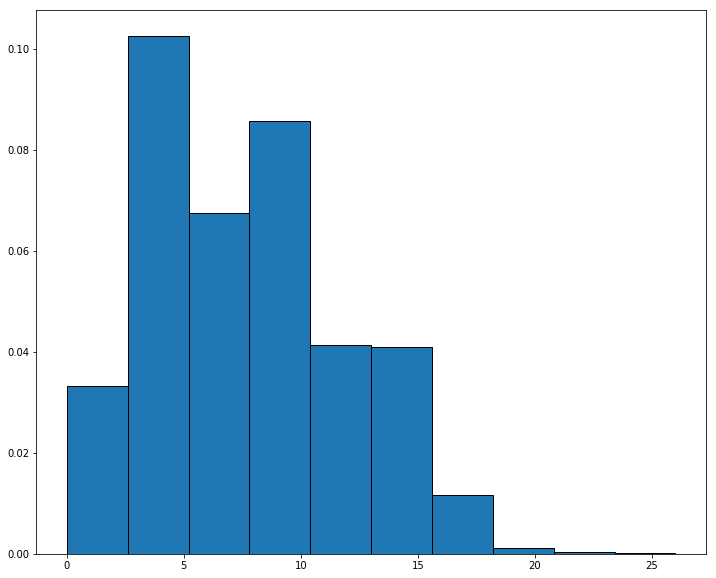

In [16]:
plt.subplots(figsize=(12,10))
plt.hist(lengths, normed=True,edgecolor='black')

In [17]:
#loading Google Word2Vec
def load_google_word2vec(file_name):
    return KeyedVectors.load_word2vec_format(file_name, binary=True)

In [18]:
word2vec_model= load_google_word2vec('word_embeddings/GoogleNews-vectors-negative300.bin')

In [24]:
def get_word2vec_embedding_matrix(model,sentence):
    tokens = sentence.split()
    embedding_matrix = np.zeros((max_length,300))
    for i,word in enumerate(tokens):
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [26]:
get_word2vec_embedding_matrix(word2vec_model,trainX[0])

array([[-0.03662109,  0.01452637,  0.03515625, ..., -0.12011719,
         0.05029297,  0.140625  ],
       [-0.06298828,  0.03149414, -0.30273438, ..., -0.08984375,
         0.09863281, -0.03637695],
       [ 0.01782227, -0.11669922, -0.35351562, ..., -0.11962891,
         0.24023438,  0.07324219],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])